## prepare

### packages 

In [676]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import lightgbm

import sklearn
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import accuracy_score,auc

from matplotlib.ticker import FormatStrFormatter
from bayes_opt import BayesianOptimization

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### data load

In [677]:
train = pd.read_csv('C:/Users/rsh15/Desktop/seunghuni/dataset/open data/open data/train.csv')
test  = pd.read_csv('C:/Users/rsh15/Desktop/seunghuni/dataset/open data/open data/test_x.csv')
train.drop('index',axis=1,inplace=True)
test.drop('index',axis=1,inplace=True)

## data ready

### marci_score

In [678]:
col_pos = ['QbA','QcA','QhA','QjA','QmA','QoA','QsA']
pre_pos = ['QlA','QpA','QtA']
col_neg = ['QeA','QfA','QkA','QqA','QrA']
pre_neg = ['QaA','QdA','QgA','QiA','QnA']

In [679]:
rep_idx = {1:5,2:4,3:3,4:2,5:1}

In [680]:
# train
train_marci_neg = train.loc[:,col_neg+pre_neg].replace(rep_idx)
train_marci_pos = train.loc[:,col_pos+pre_pos]
train_marci_score = pd.concat([train_marci_neg,train_marci_pos],axis=1).sum(axis=1)
train_marci_score.head(3)

0    59.0
1    52.0
2    38.0
dtype: float64

In [681]:
# test
test_marci_neg = test.loc[:,col_neg+pre_neg].replace(rep_idx)
test_marci_pos = test.loc[:,col_pos+pre_pos]
test_marci_score = pd.concat([test_marci_neg,test_marci_pos],axis=1).sum(axis=1)
test_marci_score.head(3)

0    49.0
1    56.0
2    71.0
dtype: float64

### age

In [682]:
train['age_group'] = train['age_group'].replace(dict(zip(np.unique(train['age_group'].values),['70','10','20','30','40','50','60'])))

In [683]:
test['age_group'] = test['age_group'].replace(dict(zip(np.unique(test['age_group'].values),['70','10','20','30','40','50','60'])))

### marci_answer_time

In [684]:
marci_time_col = train.columns[(pd.Series(train.columns).str.startswith('Q')) & (pd.Series(train.columns).str.endswith('E'))]
marci_time_col

Index(['QaE', 'QbE', 'QcE', 'QdE', 'QeE', 'QfE', 'QgE', 'QhE', 'QiE', 'QjE',
       'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE', 'QsE', 'QtE'],
      dtype='object')

In [685]:
# train
train_plus_time = train.loc[:,col_pos+pre_pos].mean(axis=1)
train_negg_time = train.loc[:,col_neg+pre_neg].mean(axis=1)

train_plus_time.head(3)
train_negg_time.head(3)

0    3.0
1    2.8
2    1.7
dtype: float64

0    3.1
1    3.6
2    3.9
dtype: float64

In [686]:
# test
test_plus_time = test.loc[:,col_pos+pre_pos].mean(axis=1)
test_negg_time = test.loc[:,col_neg+pre_neg].mean(axis=1)

test_plus_time.head(3)
test_negg_time.head(3)

0    2.5
1    2.9
2    3.6
dtype: float64

0    3.6
1    3.3
2    2.5
dtype: float64

### gender

In [687]:
# gender text to numeric - train
train['gender'] = train['gender'].replace('Female',0).replace('Male',1)
train['gender'].head(5)

0    0
1    0
2    1
3    0
4    1
Name: gender, dtype: int64

In [688]:
# gender text to numeric - test
test['gender'] = test['gender'].replace('Female',0).replace('Male',1)
test['gender'].head(3)

0    1
1    1
2    1
Name: gender, dtype: int64

### familysize

In [689]:
train['fam_single'] = train['familysize'].map(lambda k: 1 if k == 0 else 0)
train['fam_small']  = train['familysize'].map(lambda k: 1 if k < 5  else 0)
train['fam_co']     = train['familysize'].map(lambda k: 1 if 0 < k <= 6 else (0 if k == 0 else 2))

In [690]:
test['fam_single'] = test['familysize'].map(lambda k: 1 if k == 0 else 0)
test['fam_small']  = test['familysize'].map(lambda k: 1 if k < 5  else 0)
test['fam_co']     = test['familysize'].map(lambda k: 1 if 0 < k <= 6 else (0 if k == 0 else 2))

### education

In [691]:
train_edu_college = np.where(train['education'].isin([3,4]),1,0).tolist()
train_edu_college[0:3]

[0, 1, 1]

In [692]:
test_edu_college = np.where(test['education'].isin([3,4]),1,0).tolist()
test_edu_college[0:3]

[0, 0, 1]

### engnat

In [693]:
train['engnat'].head(3)

0    1
1    2
2    1
Name: engnat, dtype: int64

In [694]:
test['engnat'].head(3)

0    2
1    2
2    2
Name: engnat, dtype: int64

### hand

In [695]:
# hand dummies
train_hand_dummy = pd.get_dummies(train['hand'],dtype=int)
train_hand_dummy.columns = ['hand_noans','hand_right','hand_left','hand_both']
train_hand_dummy.head(5)

,hand_noans,hand_right,hand_left,hand_both
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [696]:
# hand dummies
test_hand_dummy = pd.get_dummies(test['hand'],dtype=int)
test_hand_dummy.columns = ['hand_noans','hand_right','hand_left','hand_both']
test_hand_dummy.head(5)

,hand_noans,hand_right,hand_left,hand_both
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


### married

In [697]:
# train ever married
train_ever_married = np.where(train['married'].isin([0,1]),0,1)

In [698]:
# test ever married
test_ever_married = np.where(test['married'].isin([0,1]),0,1)

### race

In [699]:
train['race'][train['race']=='Other'] = 'race_other'
train_race_dumm = pd.get_dummies(train['race'],dtype=int)

In [700]:
test['race'][test['race']=='Other'] = 'race_other'
test_race_dumm = pd.get_dummies(test['race'],dtype=int)

### religion

In [701]:
train_religion_ifA = np.where(train['religion'].str.startswith('A'),1,0).tolist()
test_religion_ifA = np.where(test['religion'].str.startswith('A'),1,0).tolist()

In [702]:
train_religion_ifC = np.where(train['religion'].str.startswith('Christian'),1,0).tolist()
test_religion_ifC = np.where(test['religion'].str.startswith('Christian'),1,0).tolist()

In [703]:
train['religion'][train['religion'] == 'Other'] ='religion_other'
test['religion'][test['religion'] == 'Other'] ='religion_other'

In [704]:
train_religion_dumm = pd.get_dummies(train['religion'],dtype=int)
test_religion_dumm = pd.get_dummies(test['religion'],dtype=int)

### tp_

In [705]:
train.loc[:,train.columns.str.startswith('tp')] = 7-train.loc[:,train.columns.str.startswith('tp')]

In [706]:
train_tp = {'extraversion' : (train['tp01'] + train['tp06'])/2,
            'agreeable' : (train['tp02'] + train['tp07'])/2,
            'conscientious' : (train['tp03'] + train['tp08'])/2,
            'emotional' : (train['tp04'] + train['tp09'])/2,
            'openess' : (train['tp05'] + train['tp10'])/2}
train_tp = pd.DataFrame(train_tp)
train_tp.head(5)

,extraversion,agreeable,conscientious,emotional,openess
0,5.5,2.5,4.0,4.5,4.5
1,5.5,5.0,5.0,7.0,4.5
2,4.0,4.5,3.5,4.0,4.0
3,4.5,4.5,5.0,6.0,5.0
4,5.5,6.5,3.5,3.0,4.0


In [707]:
test.loc[:,test.columns.str.startswith('tp')] = 7-test.loc[:,test.columns.str.startswith('tp')]

In [708]:
test_tp = {'extraversion' : (test['tp01'] + test['tp06'])/2,
           'agreeable' : (test['tp02'] + test['tp07'])/2,
           'conscientious' : (test['tp03'] + test['tp08'])/2,
           'emotional' : (test['tp04'] + test['tp09'])/2,
           'openess' : (test['tp05'] + test['tp10'])/2}
test_tp = pd.DataFrame(test_tp)
test_tp.head(5)

,extraversion,agreeable,conscientious,emotional,openess
0,5.0,5.5,5.0,3.0,4.5
1,0.0,0.0,0.0,0.0,0.0
2,3.5,5.0,4.5,5.0,3.5
3,4.0,4.5,4.0,3.5,4.0
4,4.0,4.0,5.0,4.0,4.0


### urban

In [709]:
train['urban']

0        1
1        3
2        2
3        3
4        1
        ..
45527    3
45528    1
45529    2
45530    0
45531    2
Name: urban, Length: 45532, dtype: int64

In [710]:
test['urban']

0        2
1        3
2        1
3        2
4        2
        ..
11378    0
11379    2
11380    1
11381    2
11382    3
Name: urban, Length: 11383, dtype: int64

### wr_

In [711]:
train_wr_agg = train.loc[:,train.columns.str.startswith('wr_')].mean(axis=1)
train_wf_agg = train.loc[:,train.columns.str.startswith('wf_')].mean(axis=1)

In [712]:
test_wr_agg = test.loc[:,test.columns.str.startswith('wr_')].mean(axis=1)
test_wf_agg = test.loc[:,test.columns.str.startswith('wf_')].mean(axis=1)

## data combine

### train

In [713]:
train_df = {
    'marci_score' : train_marci_score,
    'marci_plus_time' : train_plus_time,
    'marci_negg_time' : train_negg_time,
    'age' : train['age_group'],
    'gender' : train['gender'],
    'education' : train['education'].astype(str),
    'engnat' : train['engnat'],
    'married' : train_ever_married,
    'wr' : train_wr_agg,
    'wf' : train_wf_agg,
    'urban' : train['urban'].astype(str),
    'fam_single' : train['fam_single'],
    'fam_small' : train['fam_small'],
    'fam_co' : train['fam_co'],
    'voted' : train['voted']
}
train_df = pd.DataFrame(train_df)
train_df = pd.concat([train_df,train_hand_dummy,train_tp,train_race_dumm,train_religion_dumm],axis=1)
train_df.head(5)

,marci_score,marci_plus_time,marci_negg_time,age,gender,education,engnat,married,wr,wf,...,Buddhist,Christian_Catholic,Christian_Mormon,Christian_Other,Christian_Protestant,Hindu,Jewish,Muslim,Sikh,religion_other
0,59.0,3.0,3.1,30,0,2,1,1,0.538462,0.000000,...,0,0,0,0,0,0,0,0,0,1
1,52.0,2.8,3.6,20,0,4,2,0,0.615385,0.000000,...,0,0,0,0,0,1,0,0,0,0
2,38.0,1.7,3.9,30,1,3,1,1,0.769231,0.333333,...,0,0,0,0,0,0,0,0,0,1
3,67.0,3.9,3.2,20,0,4,2,0,0.384615,0.000000,...,0,0,0,0,0,1,0,0,0,0
4,60.0,2.9,2.9,20,1,3,1,1,0.846154,0.333333,...,0,0,0,0,0,0,0,0,0,0



### test

In [714]:
test_df = {
    'marci_score' : test_marci_score,
    'marci_plus_time' : test_plus_time,
    'marci_negg_time' : test_negg_time,
    'age' : test['age_group'],
    'gender' : test['gender'],
    'education' : test['education'].astype(str),
    'engnat' : test['engnat'],
    'married' : test_ever_married,
    'wr' : test_wr_agg,
    'wf' : test_wf_agg,
    'urban' : test['urban'].astype(str),
    'fam_single' : test['fam_single'],
    'fam_small' : test['fam_small'],
    'fam_co' : test['fam_co']
}
test_df = pd.DataFrame(test_df)
test_df = pd.concat([test_df,test_hand_dummy,test_tp,test_race_dumm,test_religion_dumm],axis=1)
test_df.head(5)

,marci_score,marci_plus_time,marci_negg_time,age,gender,education,engnat,married,wr,wf,...,Buddhist,Christian_Catholic,Christian_Mormon,Christian_Other,Christian_Protestant,Hindu,Jewish,Muslim,Sikh,religion_other
0,49.0,2.5,3.6,10,1,2,2,0,0.461538,0.0,...,0,0,0,0,1,0,0,0,0,0
1,56.0,2.9,3.3,10,1,2,2,0,0.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
2,71.0,3.6,2.5,30,1,3,2,1,0.538462,0.0,...,0,0,0,1,0,0,0,0,0,0
3,67.0,2.8,2.1,60,1,4,1,1,1.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
4,58.0,2.9,3.1,10,1,2,1,0,0.769231,0.0,...,0,0,0,0,0,0,0,0,0,0


### scaling, split

In [715]:
train_df['voted'] = train_df['voted'].replace({1:1,2:0})

In [716]:
# ordinal
enc = OrdinalEncoder()
train_df[['age','education','engnat']] = enc.fit_transform(train_df[['age','education','engnat']])
test_df[['age','education','engnat']] = enc.fit_transform(test_df[['age','education','engnat']])

In [717]:
# min max scaling
scaler = MinMaxScaler()
num_cols = ['marci_score','marci_plus_time','marci_negg_time','wr','wf','extraversion','agreeable','conscientious',
            'emotional','openess']
ord_cols = ['age','education','urban']
cat_cols = train_df.drop(num_cols+ord_cols+['voted'],axis=1).columns.tolist()

train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

scaler.fit(train_df_scaled[num_cols])
train_df_scaled[num_cols] = scaler.transform(train_df_scaled[num_cols])
test_df_scaled[num_cols] = scaler.transform(test_df_scaled[num_cols])


MinMaxScaler(copy=True, feature_range=(0, 1))

In [718]:
# train,test,x,y split
x_train = train_df.drop('voted',axis=1)
x_train.columns = x_train.columns.str.replace(' ','_')

train_df.columns = train_df.columns.str.replace(' ','_')
test_df.columns  = test_df.columns.str.replace(' ','_')
train_df_scaled.columns = train_df_scaled.columns.str.replace(' ','_')
test_df_scaled.columns  = test_df_scaled.columns.str.replace(' ','_')

y_train = train_df['voted']

## model

### modeling

In [674]:
from pycaret.classification import *

In [675]:
clf = setup(data=train_df,target='voted',numeric_features=num_cols,categorical_features=cat_cols,
            ordinal_features={'age' : np.unique(train_df['age']).tolist(),
                              'education':np.unique(train_df['education']).tolist(),
                              'urban':np.unique(train_df['urban']).tolist()},
            feature_selection=True,feature_selection_threshold=0.3)

ValueError: Column type forced is either target column or doesn't exist in the dataset.

In [ ]:
best_3 = compare_models(sort = 'AUC', n_select = 3)

In [ ]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

In [ ]:
pred_holdout = predict_model(blended)

#### lgbm tuning

In [ ]:
pyca_params = {
    'learning_rate' : [0.01,0.03,0.05,0.07,0.1],
    'n_estimators' : [100,300,500,700,1000],
    'boosting_type' : ['gbdt','dart']
}

In [ ]:
pycar_tuned = tune_model(best_3[1],custom_grid = pyca_params)

In [ ]:
plot_model(best_3[2],'feature')

In [ ]:
['marci_score','marci_negg_time','wr','marci_plus_time','education','agreeable','age','extraversion','conscientious','openess']

In [ ]:
best_3[0]

### modeling combined

In [ ]:
kfold = StratifiedKFold(n_splits=10)

In [ ]:
random_state=0
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier(random_state=random_state))

In [ ]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,x_train,y=y_train,scoring='roc_auc',cv=kfold,n_jobs=-1))

In [ ]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    

In [ ]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["SVC","RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron",
                                    "LogisticRegression","LinearDiscriminantAnalysis",'LGBM']})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g.set_title("Cross validation scores")
g.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
g.set_xlim([0.1,0.8])

In [ ]:
cv_res.sort_values('CrossValMeans',ascending=False)

In [ ]:
x_train['urban'] = x_train['urban'].astype(int)

In [ ]:
# lgbm between dart and gbdt?
boost_grid = {'boosting_type':['gbdt','dart','goss']}
lgb = LGBMClassifier()
gsv = GridSearchCV(lgb,param_grid=boost_grid,cv=10)
gsv.fit(x_train,y_train)

In [ ]:
pd.DataFrame({
  'boosting'   : ['gbdt','dart','goss'],
  'mean_score' : gsv.cv_results_['mean_test_score']
})

In [ ]:
params_lgbm = {
    'application':['Binary'],
    'Task':['train'],
    'boosting_type' : ['gbdt'],
    'max_depth':range(1,21,1)
}
# accuracy might be bad since you didnt set num_leaves and 2^max_depth > num_leaves

In [ ]:
lgb = LGBMClassifier()
gsv = GridSearchCV(lgb,param_grid=params_lgbm,cv=10)
gsv.fit(x_train,y_train)

In [ ]:
gsv.best_score_
gsv.best_params_

#### LGBM

In [ ]:
lgbm_params = {
    'boosting_type' : 'gbdt',
    'learning_rate' : 0.01,
    'max_depth' : 10
}

lgbm = lightgbm.LGBMClassifier(**lgbm_params)
lgbm.fit(x_train,y_train)

In [ ]:
kfold = StratifiedKFold(5,shuffle=True,random_state=1996)
cross_val_score(lgbm,x_train,y_train,cv=kfold).mean()

In [ ]:
# learning rate
# boosting dart : score 0.688 with 0.06
# boosting gbdt : score 0.688 with 0.03
result_list = []
kfold = StratifiedKFold(5,shuffle=True,random_state=1996)

for k in np.arange(0.01,0.11,0.01):
    lgbm_params = {
    'boosting_type' : 'gbdt',
    'learning_rate' : k.round(2)
    }
    
    lgbm = lightgbm.LGBMClassifier(**lgbm_params)
    lgbm.fit(x_train,y_train)
    
    res = cross_val_score(lgbm,x_train,y_train,cv=kfold).mean()
    result_list.append(res)

In [ ]:
sns.lineplot(x=np.arange(0.01,0.11,0.01).round(2),y=result_list)

In [ ]:
kfold = StratifiedKFold(5,shuffle=True,random_state=0)
grid_params = {
        'boosting_type' : ['dart'],
        'learning_rate' : 0.9,
        'max_depth'     : [8],
        'num_iterations': [1000],
        'num_leaves'    : [50]
    }
lgbm = lightgbm.LGBMClassifier()

In [ ]:
cate_features = ['marci_score','marci_plus_time','marci_negg_time','extraversion','agreeable','conscientious','emotional',
                 'openess','wr','wf']
cate_features = [x_train.columns.get_loc(k) for k in cate_features]
cate_features

In [ ]:
kfold = StratifiedKFold(10,shuffle=True,random_state=0)

params = {"objective" : ["binary"], 
          "boosting_type" : ["gbdt"],
          "metric" : ["auc"],
          "learning_rate" : [0.01],
          "max_depth" : [9],
          "num_leaves" : [22],
          "min_data_in_leaf" : [200],
          "min_sum_hessian_in_leaf" : [5.0],
          "bagging_freq" : [4],
          "bagging_fraction" : [0.8],
          "verbosity" : [1],
          "n_estimators" : [1000],
          "n_jobs" : [-1]}

gsv_result = GridSearchCV(lgb,param_grid=params,cv=kfold)
gsv_result.fit(x_train,y_train)

In [ ]:
gsv_result.best_params_

In [ ]:
model = lightgbm.LGBMClassifier(**gsv_result.best_params_)
model.fit(x_train,y_train)
print('train_score',accuracy_score(y_train,model.predict(x_train)))
print('valid_score',cross_val_score(model,x_train,y_train,cv=kfold).mean())

#### bay

##### xgb

In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

kfold = StratifiedKFold(5,shuffle=True,random_state=1996)
def XGB_cv(max_depth,learning_rate, n_estimators, gamma,min_child_weight, subsample,colsample_bytree,
           reg_alpha,reg_lambda,eta):
    model = xgb.XGBClassifier(objective='binary:logistic',
                              max_depth=int(max_depth),
                              learning_rate=learning_rate,
                              n_estimators=int(n_estimators),
                              gamma=gamma,
                              min_child_weight=min_child_weight,
                              subsample=subsample,
                              colsample_bytree=colsample_bytree,
                              eta=eta,
                              reg_alpha = reg_alpha,
                              reg_lambda = reg_lambda)
    RMSE = cross_val_score(model, xx, y_train, scoring='roc_auc', cv=5).mean()
    return -RMSE

In [ ]:
pbounds = {'max_depth': (3, 10),
          'learning_rate': (0.01, 0.3),
          'n_estimators': (50, 3000),
          'gamma': (0,20),
          'min_child_weight': (1, 20),
          'subsample': (0.1, 0.8),
          'colsample_bytree' :(0.1, 0.99),
          'eta':(0.01,0.5),
          'reg_alpha':(0.001,0.1),
          'reg_lambda':(0.001,0.1)
          }

In [ ]:
xgboostBO = BayesianOptimization(f = XGB_cv,pbounds = pbounds, verbose = 2, random_state = 1996)

In [ ]:
xgboostBO.maximize(init_points=20, n_iter = 20)

In [ ]:
xgb_result = []
xgb_params = []
for a, b in enumerate(xgboostBO.res):
    pp = b['params']
    pp['max_depth'] = int(pp['max_depth'])
    pp['n_estimators'] = int(pp['n_estimators'])
    pp['min_child_weight'] = int(pp['min_child_weight'])
    xgb_params.append(pp)
    xgb_result.append(b['target'])

In [ ]:
pd.concat([pd.DataFrame(xgb_params),pd.DataFrame(xgb_result)],axis=1).sort_values(0)

##### lgbm

In [ ]:
kfold_bay = StratifiedKFold(5,shuffle=True,random_state=0)
def lgb_bayesian(n_estimators,num_leaves, learning_rate, max_depth, feature_fraction):
    model = lightgbm.LGBMClassifier(
            objective = "binary", 
            boosting_type = "dart",
            metric = "auc",
            n_estimators = int(n_estimators),
            num_leaves = int(round(num_leaves)),
            learning_rate = learning_rate,
            max_depth = int(round(max_depth)),
            feature_fraction = feature_fraction)
    
    score = cross_val_score(model,xx,y_train,cv=kfold_bay,scoring='roc_auc').mean()
    return -score

In [ ]:
lgbm_params = {
    'n_estimators':(5,3000),
    'num_leaves': (5, 45),
    'learning_rate':(0.01,0.3),
    'max_depth': (3,10),
    'feature_fraction': (0.1, 0.9)
}

In [ ]:
lgbm_bayesian = BayesianOptimization(f = lgb_bayesian,pbounds = lgbm_params, verbose = 2, random_state = 1996)

In [ ]:
lgbm_bayesian.maximize(init_points=20, n_iter = 20)

In [ ]:
lgbm_bayesian.max

In [ ]:
#### gbdt

In [ ]:
kfold_bay = StratifiedKFold(5,shuffle=True,random_state=0)
def lgb_bayesian_gbdt(n_estimators,num_leaves, learning_rate, max_depth, feature_fraction, bagging_freq,
                 bagging_fraction, lambda_l1, lambda_l2,min_split_gain,min_child_weight):
    model = lightgbm.LGBMClassifier(
            objective = "binary", 
            boosting_type = "gbdt",
            metric = "auc",
            n_estimators = int(n_estimators),
            num_leaves = int(round(num_leaves)),
            learning_rate = learning_rate,
            max_depth = int(round(max_depth)),
            feature_fraction = feature_fraction,
            bagging_freq = int(bagging_freq),
            bagging_fraction = bagging_fraction,
            lambda_l1 = lambda_l1,
            lambda_l2 = lambda_l2,
            min_split_gain = min_split_gain,
            min_child_weight = int(min_child_weight))
    
    score = cross_val_score(model,xx,y_train,cv=kfold_bay,scoring='roc_auc').mean()
    return -score

In [ ]:
lgbm_params = {
    'n_estimators':(5,3000),
    'num_leaves': (5, 45),
    'learning_rate':(0.01,0.3),
    'max_depth': (5,10),
    'feature_fraction': (0.1, 0.9),
    'bagging_freq':(3,10),
    'bagging_fraction': (0.01, 1),
    'lambda_l1': (0, 100),
    'lambda_l2': (0, 100),
    'min_split_gain': (0.001, 0.1),
    'min_child_weight': (5, 100)
}

In [ ]:
lgbm_bayesian_gbdt = BayesianOptimization(f = lgb_bayesian_gbdt,pbounds = lgbm_params, verbose = 2, random_state = 1996)

In [ ]:
lgbm_bayesian_gbdt.maximize(init_points=20, n_iter = 20)

##### MLP

In [ ]:
mlp_param = { 
        'activation' : Categorical(['identity', 'logistic', 'tanh', 'relu']),
        'solver' : Categorical(['lbfgs', 'sgd', 'adam']),
        'alpha' : Real(1e-6, 1e-2, prior='log-uniform'),
        'learning_rate' : Categorical(['constant', 'invscaling', 'adaptive']),
        'max_iter' : Integer(100, 500)
    }

In [ ]:
md = MLPClassifier()

In [ ]:
opt = BayesSearchCV(md, mlp_param, n_iter=50, cv=10, n_jobs=-1, refit=True, random_state=123)
opt.fit(xx, y_train)

##### model binding

In [ ]:
xgb_best  = xgboostBO.max['params']
lgbm_best = lgbm_bayesian.max['params']
mlpm_best = mlpm_bayesian.max['params']

In [ ]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,y_train,test_size=0.2,random_state=1996)

In [ ]:
xgb_best['max_depth'] = int(xgb_best['max_depth'])
xgb_best['n_estimators'] = int(xgb_best['n_estimators'])
xgb_best['min_child_weight'] = int(xgb_best['min_child_weight'])
lgbm_best['num_leaves'] = int(lgbm_best['num_leaves'])
lgbm_best['max_depth'] = int(lgbm_best['max_depth'])
lgbm_best['bagging_freq'] = int(lgbm_best['bagging_freq'])
mlpm_best['max_iter'] = int(mlpm_best['max_iter'])

In [ ]:
xgb_bestmd = xgb.XGBClassifier(**xgb_best) 
lgb_bestmd = lightgbm.LGBMClassifier(**lgbm_best)
mlp_bestmd = MLPClassifier(**mlpm_best)

In [ ]:
cross_val_score(xgb_bestmd,xx,y_train,cv=10).mean()
cross_val_score(lgb_bestmd,xx,y_train,cv=10).mean()
cross_val_score(mlp_bestmd,xx,y_train,cv=10).mean()

### keras

In [813]:
from tensorflow.keras import models,layers
import kerastuner as kt
import tensorflow.keras as keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [969]:
cols_sel = ['marci_score','marci_negg_time','wr','marci_plus_time','education','agreeable','age','extraversion',
            'conscientious','openess']
train_for_keras = train_df_scaled.copy().drop('voted',axis=1)
test_for_keras = test_df_scaled.copy()

In [970]:
train_for_keras.head(5)
test_for_keras.head(5)
train_for_keras.shape
test_for_keras.shape

,marci_score,marci_plus_time,marci_negg_time,age,gender,education,engnat,married,wr,wf,...,Buddhist,Christian_Catholic,Christian_Mormon,Christian_Other,Christian_Protestant,Hindu,Jewish,Muslim,Sikh,religion_other
0,0.4875,0.500,0.525,2.0,0,2.0,1.0,1,0.538462,0.000000,...,0,0,0,0,0,0,0,0,0,1
1,0.4000,0.450,0.650,1.0,0,4.0,2.0,0,0.615385,0.000000,...,0,0,0,0,0,1,0,0,0,0
2,0.2250,0.175,0.725,2.0,1,3.0,1.0,1,0.769231,0.333333,...,0,0,0,0,0,0,0,0,0,1
3,0.5875,0.725,0.550,1.0,0,4.0,2.0,0,0.384615,0.000000,...,0,0,0,0,0,1,0,0,0,0
4,0.5000,0.475,0.475,1.0,1,3.0,1.0,1,0.846154,0.333333,...,0,0,0,0,0,0,0,0,0,0


,marci_score,marci_plus_time,marci_negg_time,age,gender,education,engnat,married,wr,wf,...,Buddhist,Christian_Catholic,Christian_Mormon,Christian_Other,Christian_Protestant,Hindu,Jewish,Muslim,Sikh,religion_other
0,0.3625,0.375,0.650,0.0,1,2.0,2.0,0,0.461538,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.4500,0.475,0.575,0.0,1,2.0,2.0,0,0.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
2,0.6375,0.650,0.375,2.0,1,3.0,2.0,1,0.538462,0.0,...,0,0,0,1,0,0,0,0,0,0
3,0.5875,0.450,0.275,5.0,1,4.0,1.0,1,1.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
4,0.4750,0.475,0.525,0.0,1,2.0,1.0,0,0.769231,0.0,...,0,0,0,0,0,0,0,0,0,0


(45532, 42)

(11383, 42)

In [971]:
k_x_train,k_x_valid,k_y_train,k_y_valid = train_test_split(train_for_keras,y_train,shuffle=True,test_size=0.2,random_state=1996)

In [972]:
k_x_train = np.array(k_x_train).astype('float32')
k_x_valid = np.array(k_x_valid).astype('float32')
k_y_train = np.array(k_y_train).astype('float32')
k_y_valid = np.array(k_y_valid).astype('float32')

In [978]:
keras_md = models.Sequential()
keras_md.add(layers.Dense(8,activation='relu'))
keras_md.add(layers.Dense(8,activation='relu'))
keras_md.add(layers.Dense(1, activation='sigmoid'))

keras_md.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['acc'])

In [979]:
result_md = keras_md.fit(k_x_train,k_y_train,
                         epochs = 50,batch_size=512,
                         validation_data = (k_x_valid,k_y_valid))

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.7063 - acc: 0.460 - ETA: 0s - loss: 0.6874 - acc: 0.467 - ETA: 0s - loss: 0.6799 - acc: 0.538 - 0s 5ms/step - loss: 0.6794 - acc: 0.5443 - val_loss: 0.6598 - val_acc: 0.6796
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.6585 - acc: 0.664 - ETA: 0s - loss: 0.6582 - acc: 0.670 - ETA: 0s - loss: 0.6488 - acc: 0.673 - 0s 3ms/step - loss: 0.6470 - acc: 0.6739 - val_loss: 0.6254 - val_acc: 0.6827
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.6193 - acc: 0.685 - ETA: 0s - loss: 0.6243 - acc: 0.674 - ETA: 0s - loss: 0.6197 - acc: 0.671 - ETA: 0s - loss: 0.6159 - acc: 0.672 - 0s 3ms/step - loss: 0.6159 - acc: 0.6721 - val_loss: 0.6000 - val_acc: 0.6771
Epoch 4/50
72/72 [==============================] - ETA: 0s - loss: 0.6115 - acc: 0.666 - ETA: 0s - loss: 0.6044 - acc: 0.670 - ETA: 0s - loss: 0.6009 - acc: 0.672 - 0s 3ms/step - loss: 0.5995 - acc: 0.6735 - val_loss: 0.5887 - va

72/72 [==============================] - ETA: 0s - loss: 0.5450 - acc: 0.699 - ETA: 0s - loss: 0.5605 - acc: 0.693 - ETA: 0s - loss: 0.5602 - acc: 0.694 - 0s 2ms/step - loss: 0.5589 - acc: 0.6938 - val_loss: 0.5611 - val_acc: 0.6950
Epoch 35/50
72/72 [==============================] - ETA: 0s - loss: 0.5467 - acc: 0.714 - ETA: 0s - loss: 0.5553 - acc: 0.698 - ETA: 0s - loss: 0.5577 - acc: 0.696 - 0s 3ms/step - loss: 0.5589 - acc: 0.6952 - val_loss: 0.5625 - val_acc: 0.6951
Epoch 36/50
72/72 [==============================] - ETA: 0s - loss: 0.5787 - acc: 0.668 - ETA: 0s - loss: 0.5584 - acc: 0.694 - ETA: 0s - loss: 0.5583 - acc: 0.695 - 0s 3ms/step - loss: 0.5586 - acc: 0.6950 - val_loss: 0.5591 - val_acc: 0.6975
Epoch 37/50
72/72 [==============================] - ETA: 0s - loss: 0.5779 - acc: 0.685 - ETA: 0s - loss: 0.5610 - acc: 0.691 - ETA: 0s - loss: 0.5581 - acc: 0.695 - 0s 3ms/step - loss: 0.5586 - acc: 0.6947 - val_loss: 0.5591 - val_acc: 0.6957
Epoch 38/50
72/72 [=============

In [980]:
history = result_md.history
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

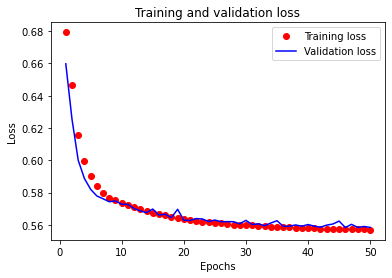

In [981]:
# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss',c='red')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

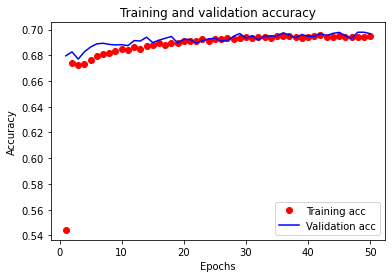

In [982]:
plt.plot(epochs, acc, 'bo', label='Training acc',c='red')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [856]:
import plotly.express as px
px.line(val_acc)

In [891]:
te_loss,te_acc = keras_md.evaluate(k_x_valid,k_y_valid)

285/285 [==============================] - ETA: 0s - loss: 0.5978 - acc: 0.687 - ETA: 0s - loss: 0.5775 - acc: 0.667 - ETA: 0s - loss: 0.5852 - acc: 0.655 - ETA: 0s - loss: 0.5793 - acc: 0.660 - ETA: 0s - loss: 0.5799 - acc: 0.656 - ETA: 0s - loss: 0.5799 - acc: 0.660 - 0s 1ms/step - loss: 0.5787 - acc: 0.6631


In [892]:
te_loss
te_acc

0.5786585807800293

0.6631162762641907

In [893]:
tr_loss,tr_acc = keras_md.evaluate(k_x_train,k_y_train)

1139/1139 [==============================] - ETA: 0s - loss: 0.6038 - acc: 0.625 - ETA: 1s - loss: 0.5759 - acc: 0.677 - ETA: 1s - loss: 0.5814 - acc: 0.671 - ETA: 1s - loss: 0.5840 - acc: 0.665 - ETA: 1s - loss: 0.5786 - acc: 0.664 - ETA: 1s - loss: 0.5823 - acc: 0.665 - ETA: 1s - loss: 0.5822 - acc: 0.662 - ETA: 0s - loss: 0.5813 - acc: 0.664 - ETA: 0s - loss: 0.5791 - acc: 0.665 - ETA: 0s - loss: 0.5766 - acc: 0.668 - ETA: 0s - loss: 0.5768 - acc: 0.668 - ETA: 0s - loss: 0.5787 - acc: 0.667 - ETA: 0s - loss: 0.5776 - acc: 0.667 - ETA: 0s - loss: 0.5782 - acc: 0.666 - ETA: 0s - loss: 0.5790 - acc: 0.667 - ETA: 0s - loss: 0.5791 - acc: 0.667 - ETA: 0s - loss: 0.5784 - acc: 0.668 - ETA: 0s - loss: 0.5787 - acc: 0.667 - ETA: 0s - loss: 0.5791 - acc: 0.666 - ETA: 0s - loss: 0.5789 - acc: 0.666 - ETA: 0s - loss: 0.5790 - acc: 0.666 - 1s 932us/step - loss: 0.5785 - acc: 0.6665


In [894]:
tr_loss
tr_acc

0.5784574747085571

0.6664928197860718

In [895]:
keras_md.predict(test_for_keras)

array([[0.17645305],
       [0.03769168],
       [0.5396986 ],
       ...,
       [0.6520562 ],
       [0.5725282 ],
       [0.4904907 ]], dtype=float32)